# **Setswana Dataset**

# 1. Setup and Imports

In [ ]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('punkt_tab')

print("Setup Complete. NLTK resources 'punkt' and 'punkt_tab' are ready.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Setup Complete. NLTK resources 'punkt' and 'punkt_tab' are ready.


# 2. Load and Filter the Setswana Dataset

In [ ]:
df = pd.read_csv('setswana_tweets.csv')
df_setswana = df[df['predict_name'] == 'Setswana'].copy()
df_setswana.dropna(subset=['sentence', 'Final_Label'], inplace=True)

print("Filtered Setswana Data:")
print(df_setswana.head())
print(f"\nOriginal shape: {df.shape}")
print(f"Shape after filtering for Setswana: {df_setswana.shape}")

Filtered Setswana Data:
                                            sentence Final_Label predict_name
0  @user lol o dramatic stocko se teng mo lwena mos     positive     Setswana
1    @user i m happy with my current piece job ausi     positive     Setswana
2   o ntate wane a tlang le mane o dieta tsa hae ...    positive     Setswana
3                                 ka dikuku my love     positive     Setswana
4  @user yeah i doubt much will be done ka kgang ...    negative     Setswana

Original shape: (3000, 3)
Shape after filtering for Setswana: (2407, 3)


# 3. Clean and Prepare the Text

In [ ]:
def clean_text(text):
    """
    Cleans a text string by lowercasing, removing links, mentions,
    and non-alphabetic characters.
    """
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df_setswana['cleaned_sentence'] = df_setswana['sentence'].apply(clean_text)
df_setswana['tokens'] = df_setswana['cleaned_sentence'].apply(word_tokenize)

print("DataFrame after Cleaning and Tokenization:")
print(df_setswana[['sentence', 'cleaned_sentence', 'tokens', 'Final_Label']].head())

DataFrame after Cleaning and Tokenization:
                                            sentence  \
0  @user lol o dramatic stocko se teng mo lwena mos    
1    @user i m happy with my current piece job ausi    
2   o ntate wane a tlang le mane o dieta tsa hae ...   
3                                 ka dikuku my love    
4  @user yeah i doubt much will be done ka kgang ...   

                                    cleaned_sentence  \
0         lol o dramatic stocko se teng mo lwena mos   
1           i m happy with my current piece job ausi   
2  o ntate wane a tlang le mane o dieta tsa hae s...   
3                                  ka dikuku my love   
4    yeah i doubt much will be done ka kgang ya teng   

                                              tokens Final_Label  
0  [lol, o, dramatic, stocko, se, teng, mo, lwena...    positive  
1  [i, m, happy, with, my, current, piece, job, a...    positive  
2  [o, ntate, wane, a, tlang, le, mane, o, dieta,...    positive  
3              

# 4. Visualize the Setswana Data

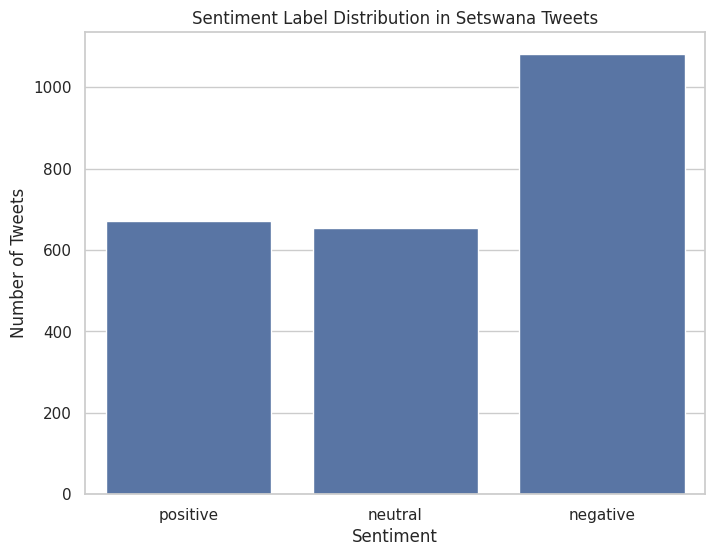

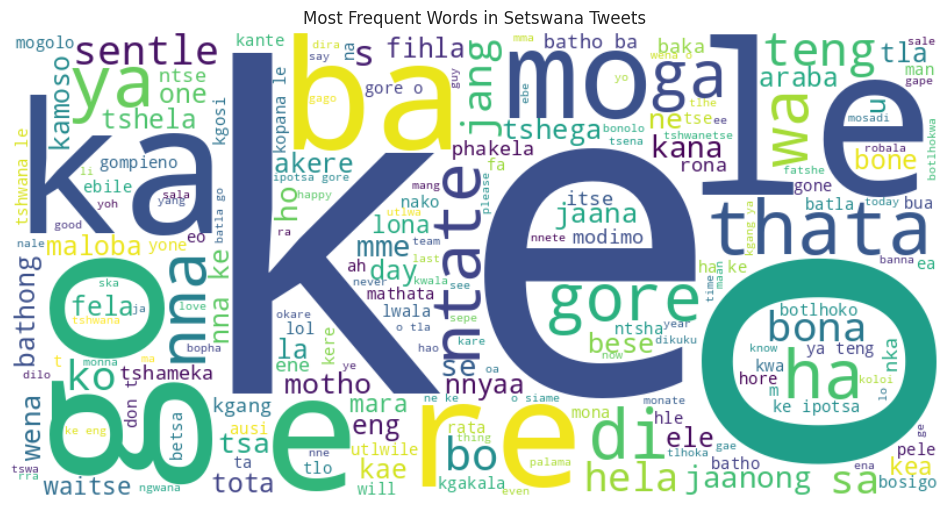

<ipython-input-4-612391628>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Word', data=most_common_words, palette='viridis')


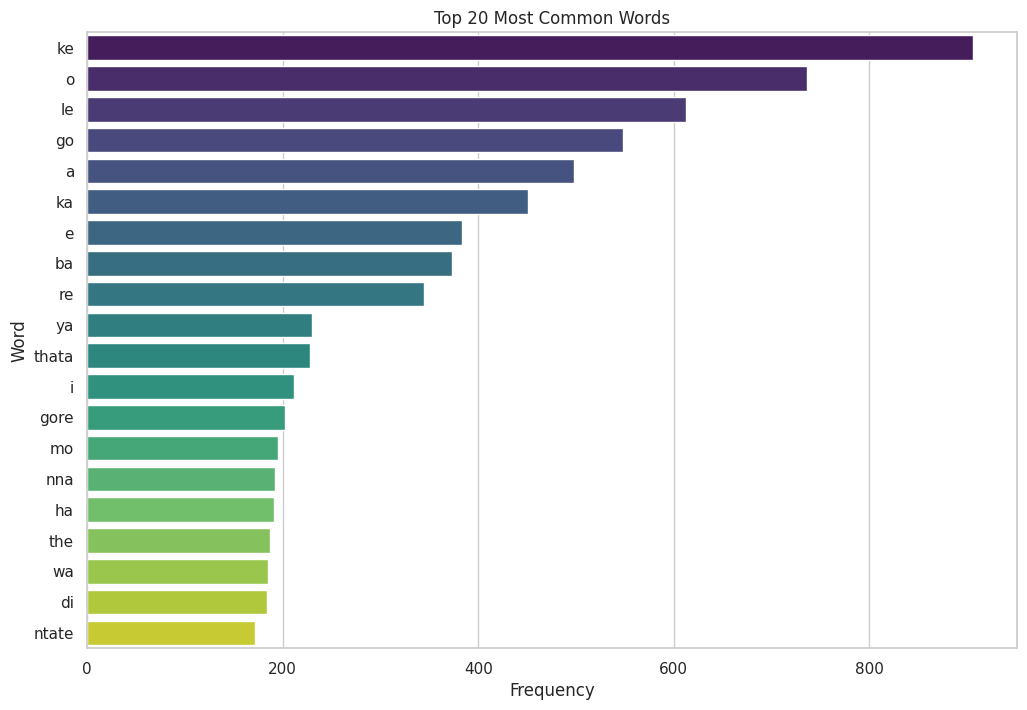

In [ ]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.countplot(x='Final_Label', data=df_setswana, order=['positive', 'neutral', 'negative'])
plt.title('Sentiment Label Distribution in Setswana Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

all_words = ' '.join(df_setswana['cleaned_sentence'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Setswana Tweets')
plt.show()

token_list = [token for sublist in df_setswana['tokens'] for token in sublist]
word_counts = Counter(token_list)
most_common_words = pd.DataFrame(word_counts.most_common(20), columns=['Word', 'Count'])

plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Word', data=most_common_words, palette='viridis')
plt.title('Top 20 Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# 5. Handle Class Imbalance with SMOTE(Synthetic Minority Over-sampling Technique)

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(df_setswana['cleaned_sentence'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_setswana['Final_Label'])

print("Original class distribution:", Counter(y))
print("Labels mapping:", {i: label for i, label in enumerate(label_encoder.classes_)})

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\nResampled class distribution:", Counter(y_resampled))
print("The classes are now balanced.")

Original class distribution: Counter({np.int64(0): 1081, np.int64(2): 672, np.int64(1): 654})
Labels mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}

Resampled class distribution: Counter({np.int64(2): 1081, np.int64(0): 1081, np.int64(1): 1081})
The classes are now balanced.


# 6. Get Data Ready for Training (Train-Test Split)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,
    y_resampled,
    test_size=0.2,
    random_state=42,
    stratify=y_resampled
)

print("Shape of the training features:", X_train.shape)
print("Shape of the testing features:", X_test.shape)
print("Shape of the training labels:", y_train.shape)
print("Shape of the testing labels:", y_test.shape)

print("\nData is now cleaned, balanced, and split. It is ready for model training.")

Shape of the training features: (2594, 5000)
Shape of the testing features: (649, 5000)
Shape of the training labels: (2594,)
Shape of the testing labels: (649,)

Data is now cleaned, balanced, and split. It is ready for model training.


# downloading the data

In [ ]:
# Save the cleaned Setswana tweets dataset
df_setswana.to_csv('cleaned_setswana_tweets.csv', index=False)
print(" Cleaned dataset saved as 'cleaned_setswana_tweets.csv'")

# OPTIONAL: For Google Colab users, enable download
try:
    from google.colab import files
    files.download('cleaned_setswana_tweets.csv')
    print(" File download triggered in Google Colab")
except ImportError:
    print("Not running in Colab. File saved locally.")


 Cleaned dataset saved as 'cleaned_setswana_tweets.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

 File download triggered in Google Colab
